In [1]:
    ###################################################################################################
    ####
    #este ejemplo esta basado en
    #https://blog.quantinsti.com/machine-learning-classification-strategy-python/?utm_source=quora&utm_medium=answer_is
    ####
    ###################################################################################################
    #Carga las librerías
    !pip install pandas_datareader
    # Machine learning classification libraries
    from sklearn.svm import SVC
    from sklearn.metrics import scorer
    from sklearn.metrics import accuracy_score
     
    # For data manipulation
    import pandas as pd
    import numpy as np
     
    # To plot
    import matplotlib.pyplot as plt
    import seaborn
     
    # To fetch data
    from pandas_datareader import data as pdr

     |████████████████████████████████| 112kB 32.1MB/s 
You should consider upgrading via the 'pip install --upgrade pip' command.


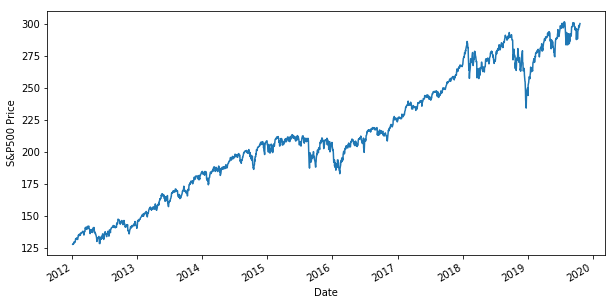

In [28]:
#importa los datos de Yahoo y los plotea

    Df = pdr.get_data_yahoo('SPY', start="2012-01-01") 
#    Df = pdr.get_data_yahoo('SPY', start="2012-01-01", end="2017-10-01") 
    
    Df= Df.dropna()
    Df.Close.plot(figsize=(10,5))
    plt.ylabel("S&P500 Price")
    plt.show()

In [29]:
# Variable a estimar
Df['Return3'] = np.log(Df.Close.shift(-1) / Df.Close)
y = pd.DataFrame(np.where(Df['Return3']> 0,1,-1))
#y=y.shift(-1)
y=y.fillna(0)
y.tail()


,0
1959,1
1960,-1
1961,1
1962,1
1963,-1


In [30]:
# Creaación de Features
    Df['Open-Close'] = Df.Open - Df.Close
    Df['High-Low'] = Df.High - Df.Low
     
    X=Df[['Open-Close','High-Low']]
    ''' 	Open-Close 	High-Low
Date 		
2017-09-25 	0.220001 	1.470001
2017-09-26 	0.339996 	0.889999
2017-09-27 	-0.169998 	1.620010
2017-09-28 	-0.620010 	0.809998
2017-09-29 	-0.889999 	1.190002'''
    X.tail()
    

,Open-Close,High-Low
Date,,
2019-10-16,-0.029999,1.239990
2019-10-17,0.399994,1.720001
2019-10-18,0.720001,2.369995
2019-10-21,-0.569977,1.269989
2019-10-22,-0.010010,0.628998


In [31]:
# Split la muestra entre InSample y OutSample
    split_percentage = 0.8
    split = int(split_percentage*len(Df))
     
    # Train data set
    X_train = X[:split]
    y_train = y[:split]
     
    # Test data set
    X_test = X[split:]
    y_test = y[split:]
    '''            Open-Close  High-Low
Date                            
2016-08-01    0.250000  1.239990
2016-08-02    1.099991  2.259995
2016-08-03   -0.699997  1.119995
2016-08-04   -0.100006  2.529999
2016-08-05   -1.769989  1.819992
      0
1151 -1
1152  1
1153  1
1154  1
1155 -1'''
    
    print(X_train.tail())
    print(y_train.tail())


            Open-Close  High-Low
Date                            
2018-03-26   -2.979980  6.019989
2018-03-27    5.570007  7.929993
2018-03-28    0.920013  4.060028
2018-03-29   -2.029999  5.420013
2018-04-02    5.079987  8.460007
      0
1566 -1
1567 -1
1568  1
1569 -1
1570  1


In [32]:
#Creamos el modelo
    cls = SVC(gamma='auto').fit(X_train.values, np.ravel(y_train))

In [33]:
#aquí vemos el ajuste del modelo
    accuracy_train = accuracy_score(y_train, cls.predict(X_train))
     
    accuracy_test = accuracy_score(y_test, cls.predict(X_test))
    print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
    print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 55.19%
Test Accuracy: 53.18%


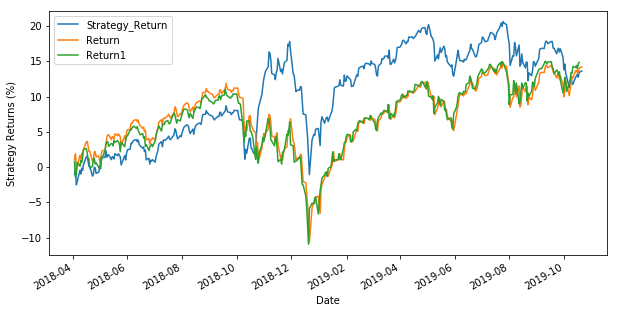

In [36]:
#Realiamos la predicción
    Df['Predicted_Signal'] = cls.predict(X)
     
    # Calculate log returns
    Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
    Df['Return1'] = Df.Close.pct_change().shift(-2)*100
    
    Df['Strategy_Return'] = Df.Return * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return1.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()



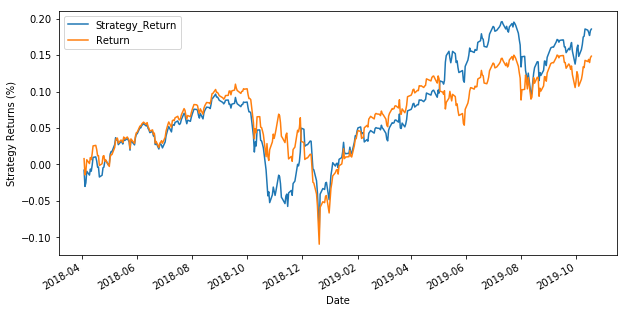

In [37]:
# Calculate log returns
    Df['Return'] = Df.Close.pct_change().shift(-2)
    Df['Strategy_Return'] = Df.Return * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()


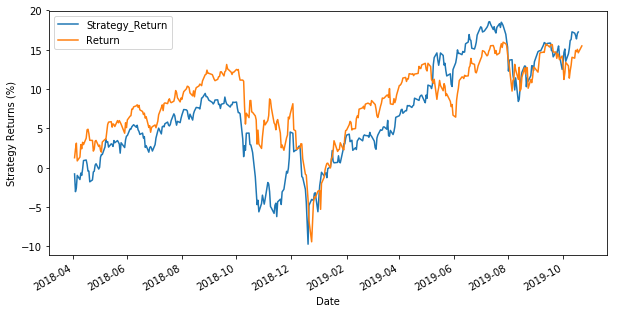

In [38]:
#Realiamos la predicción
    Df['Predicted_Signal'] = cls.predict(X)
     
    # Calculate log returns
    Df['Return'] = np.log(Df.Close / Df.Close.shift(1))*100
    Df['Strategy_Return'] = Df.Return.shift(-2) * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()



In [26]:
    Df['Return1'] = np.log(Df.Close / Df.Close.shift(1))
    Df['Return2'] = Df.Close.pct_change().shift(-1)
    Df['Return3'] = np.log(Df.Close.shift(-1) / Df.Close)

    Df[['Return1','Return2','Return3','Predicted_Signal']].tail()


,Return1,Return2,Return3,Predicted_Signal
Date,,,,
2019-10-16,-0.001607,0.002949,0.002945,1.0
2019-10-17,0.002945,-0.004377,-0.004387,1.0
2019-10-18,-0.004387,0.006779,0.006756,1.0
2019-10-21,0.006756,0.002533,0.002530,1.0
2019-10-22,0.002530,NaN,NaN,1.0
